# Assistant (Preview)


Azure OpenAI 어시스턴트(미리보기)를 통해 사용자 지정 지침을 통해 필요에 맞게 AI 어시스턴트를 만들고 코드 인터프리터 및 사용자 정의 함수와 같은 고급 도구로 보완할 수 있습니다. 이 글에서는 어시스턴트 API 사용을 시작하는 방법에 대한 심층적인 안내를 제공할 것입니다.

## API Version: 2024-02-15-preview
Check availability: 

https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#assistants-preview

## Creating an assisstant

In [2]:
import os
import json
from openai import AzureOpenAI
from dotenv import load_dotenv

# Load the environment variables from the .env file
load_dotenv()
    
client = AzureOpenAI(
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT","").strip(),
    api_key        = os.getenv("AZURE_OPENAI_API_KEY"),
    api_version    = "2024-02-15-preview"
)

deployment_name = os.getenv("DEPLOYMENT_NAME")

# Create an assistant
assistant = client.beta.assistants.create(
    name="Data Visualization",
    instructions=f"You are a helpful AI assistant who makes interesting visualizations based on data." 
    f"You have access to a sandboxed environment for writing and testing code."
    f"When you are asked to create a visualization you should follow these steps:"
    f"1. Write the code."
    f"2. Anytime you write new code display a preview of the code to show your work."
    f"3. Run the code to confirm that it runs."
    f"4. If the code is successful display the visualization."
    f"5. If the code is unsuccessful display the error message and try to revise the code and rerun going through the steps from above again.",
    tools=[{"type": "code_interpreter"}],
    model=deployment_name,
)

In [3]:
print(assistant.model_dump_json(indent=2))

{
  "id": "asst_DpaxGy4EtX4mGYpaw3L3nXT1",
  "created_at": 1734536375,
  "description": null,
  "file_ids": [],
  "instructions": "You are a helpful AI assistant who makes interesting visualizations based on data.You have access to a sandboxed environment for writing and testing code.When you are asked to create a visualization you should follow these steps:1. Write the code.2. Anytime you write new code display a preview of the code to show your work.3. Run the code to confirm that it runs.4. If the code is successful display the visualization.5. If the code is unsuccessful display the error message and try to revise the code and rerun going through the steps from above again.",
  "metadata": {},
  "model": "gpt-4o-mini",
  "name": "Data Visualization",
  "object": "assistant",
  "tools": [
    {
      "type": "code_interpreter"
    }
  ],
  "top_p": 1.0,
  "temperature": 1.0,
  "response_format": "auto"
}


## Creating a thread

Thread is a conversation session between an Assistant and a user. Threads store Messages and automatically handle truncation to fit content into a model’s context.

In [4]:
# Create a thread
thread = client.beta.threads.create()
print(thread)

Thread(id='thread_l3GvOECGOkjgBVRQQ4ZDIV6b', created_at=1734536386, metadata={}, object='thread')


In [5]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Create a visualization of a sinewave"
)

In [6]:
# list thread messages
thread_messages = client.beta.threads.messages.list(thread.id)
print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_Ur6kt5ZK0AEVTywLrY1tGR44",
      "assistant_id": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Create a visualization of a sinewave"
          },
          "type": "text"
        }
      ],
      "created_at": 1734536387,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "thread_id": "thread_l3GvOECGOkjgBVRQQ4ZDIV6b"
    }
  ],
  "object": "list",
  "first_id": "msg_Ur6kt5ZK0AEVTywLrY1tGR44",
  "last_id": "msg_Ur6kt5ZK0AEVTywLrY1tGR44",
  "has_more": false
}


In [7]:
# create a thread
# you can also use intructions here to override the default instructions
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
)

In [8]:
# retrieve thread status
# Retrieve the status of the run
run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)

status = run.status
print(status)

in_progress


In [9]:
# check the status of the run
import time
from IPython.display import clear_output

start_time = time.time()

status = run.status

while status not in ["completed", "cancelled", "expired", "failed"]:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
    print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
    status = run.status
    print(f'Status: {status}')
    clear_output(wait=True)

messages = client.beta.threads.messages.list(
  thread_id=thread.id
) 

print(f'Status: {status}')
print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
print(messages.model_dump_json(indent=2))

Status: completed
Elapsed time: 0 minutes 12 seconds
{
  "data": [
    {
      "id": "msg_s4DmtyESav6hKm1aP8LhvlcC",
      "assistant_id": "asst_DpaxGy4EtX4mGYpaw3L3nXT1",
      "content": [
        {
          "image_file": {
            "file_id": "assistant-4P8DplfJDv7SKOiR05bbRggJ"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here is the visualization of a sine wave. The x-axis represents the angle in radians, and the y-axis represents the value of the sine function. If you have any other visualizations or modifications in mind, feel free to ask!"
          },
          "type": "text"
        }
      ],
      "created_at": 1734536396,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
      "run_id": "run_6YWBlZrfkOizoKTMsxMmnnnR",
      "thread_id": "thread_l3GvOECGOkjgBVRQQ4ZDIV6b"
    },
    {
      "id": "msg_Ur6kt5ZK0AEVTywLrY1tGR44

In [10]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_s4DmtyESav6hKm1aP8LhvlcC",
      "assistant_id": "asst_DpaxGy4EtX4mGYpaw3L3nXT1",
      "content": [
        {
          "image_file": {
            "file_id": "assistant-4P8DplfJDv7SKOiR05bbRggJ"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here is the visualization of a sine wave. The x-axis represents the angle in radians, and the y-axis represents the value of the sine function. If you have any other visualizations or modifications in mind, feel free to ask!"
          },
          "type": "text"
        }
      ],
      "created_at": 1734536396,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
      "run_id": "run_6YWBlZrfkOizoKTMsxMmnnnR",
      "thread_id": "thread_l3GvOECGOkjgBVRQQ4ZDIV6b"
    },
    {
      "id": "msg_Ur6kt5ZK0AEVTywLrY1tGR44",
      "assistant_id": null,
      "content": [
   

In [11]:
# show the file name
data = json.loads(messages.model_dump_json(indent=2))  # Load JSON data into a Python object
image_file_id = data['data'][0]['content'][0]['image_file']['file_id']

print(image_file_id)  # Outputs: assistant-1YGVTvNzc2JXajI5JU9F0HMD

assistant-4P8DplfJDv7SKOiR05bbRggJ


In [12]:
# download the file
content = client.files.content(image_file_id)

image= content.write_to_file("sinewave.png")

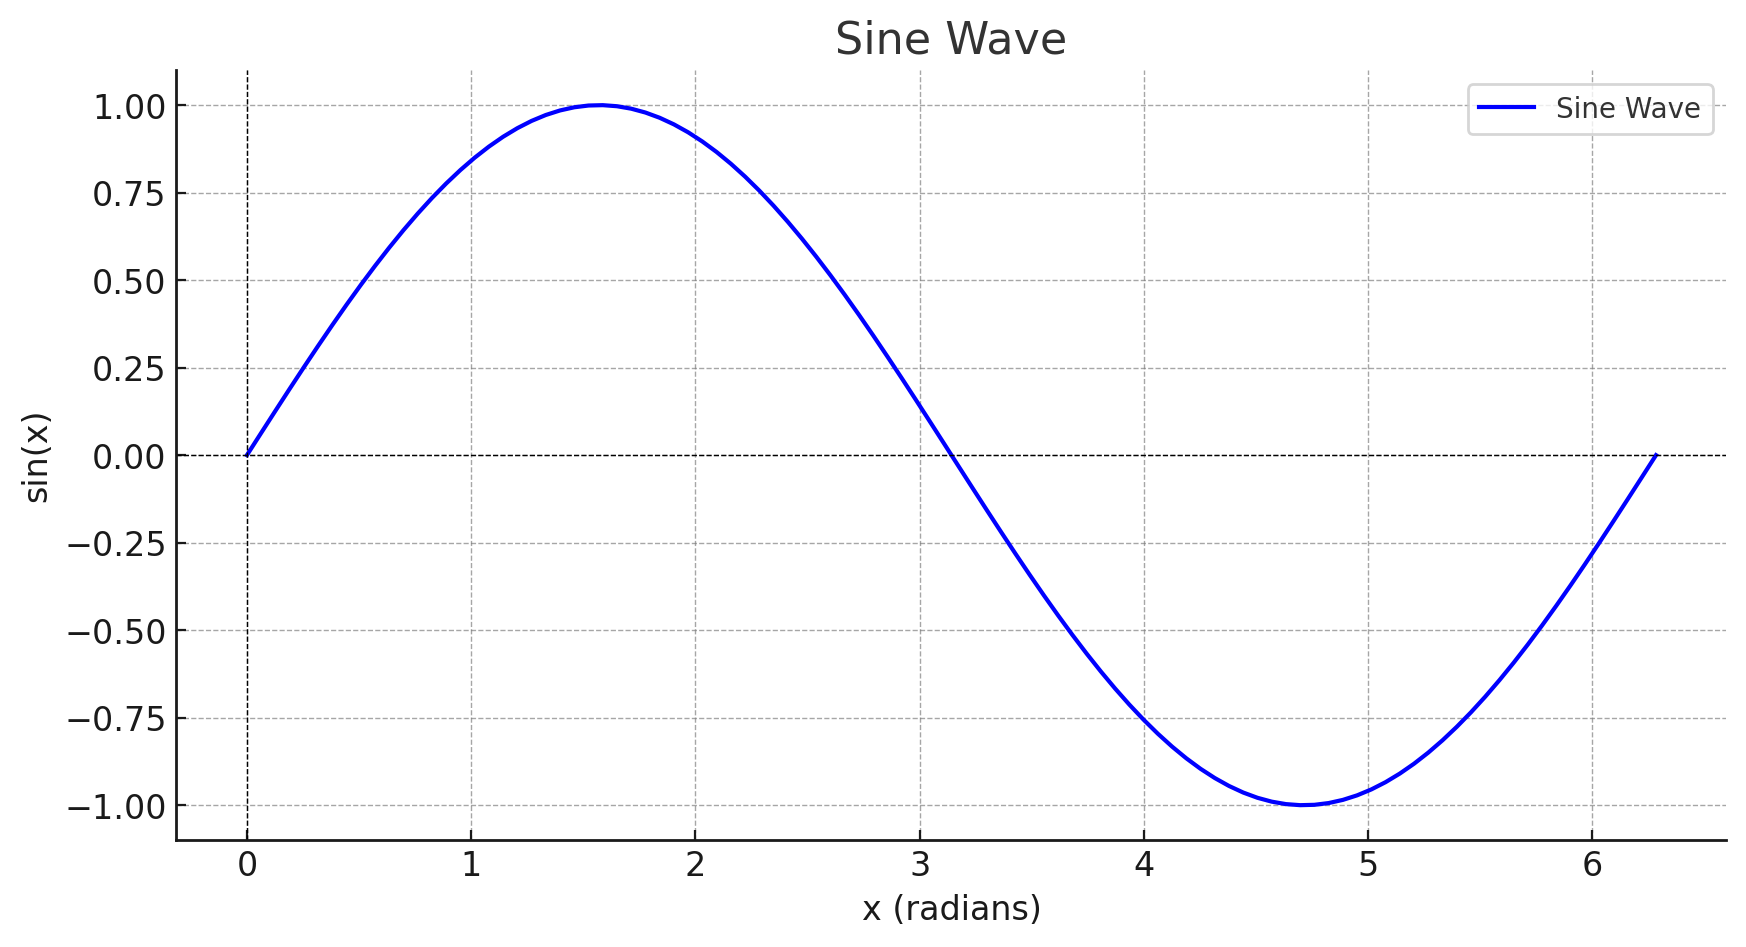

In [13]:
# rewrite the code to display the image in jupyter notebook

from PIL import Image

# Display the image in the default image viewer
image = Image.open("sinewave.png")
image.show()

## Ask follow up questions

In [14]:
# Add a new user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Show me the generated code you used to generate the sinewave"
)

In [15]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
  #instructions="New instructions" #You can optionally provide new instructions  but these will override the default instructions
)

# Retrieve the status of the run
run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)

status = run.status
print(status)

in_progress


In [16]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_K5BX8wF1iBEEtA5Q0Io9tDgV",
      "assistant_id": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Show me the generated code you used to generate the sinewave"
          },
          "type": "text"
        }
      ],
      "created_at": 1734536419,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "thread_id": "thread_l3GvOECGOkjgBVRQQ4ZDIV6b"
    },
    {
      "id": "msg_s4DmtyESav6hKm1aP8LhvlcC",
      "assistant_id": "asst_DpaxGy4EtX4mGYpaw3L3nXT1",
      "content": [
        {
          "image_file": {
            "file_id": "assistant-4P8DplfJDv7SKOiR05bbRggJ"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here is the visualization of a sine wave. The x-axis represents the angle in radians, and the y-axis represents the

In [17]:
# Print the code
data = json.loads(messages.model_dump_json(indent=2))
code = data['data'][0]['content'][0]['text']['value']
print(code)

Show me the generated code you used to generate the sinewave


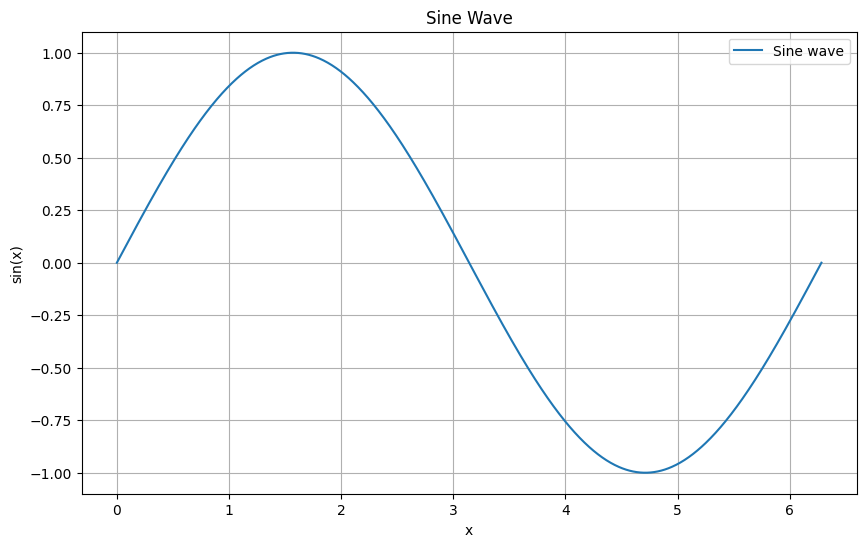

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data for the sine wave
x = np.linspace(0, 2 * np.pi, 1000)  # 1000 points between 0 and 2pi
y = np.sin(x)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Sine wave')

# Customize the plot
plt.title('Sine Wave')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()